In [61]:
%load_ext autoreload
%autoreload 2

import os
from pprint import pprint

import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.transforms import Affine2D

print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/matthew/git/cadc_testing/uncertainty_eval


In [62]:
dataset_path = '/home/matthew/git/cadc_testing/WISEOpenLidarPerceptron/data/kitti'

# Clustering
logdir = '/home/matthew/git/cadc_testing/uncertainty_eval'
preds_path = os.path.join(logdir, 'ensemble_result.pkl')
gts_path = os.path.join(logdir, 'gts.pkl')

In [63]:
def load_dicts():
    # Load gt and prediction data dict
    with open(gts_path, 'rb') as f:
        gt_dicts = pickle.load(f)
    with open(preds_path, 'rb') as f:
        pred_dicts = pickle.load(f)
    return gt_dicts, pred_dicts

def load_image(frame_id):
    img_path = os.path.join(dataset_path, 'training', 'image_2', f'{frame_id}.png')
    return plt.imread(img_path)

def load_lidar(frame_id, xlim, ylim):
    lidar_path = os.path.join(dataset_path, 'training', 'velodyne', f'{frame_id}.bin')
    points = np.fromfile(lidar_path, dtype=np.float32).reshape(-1, 4)
    valid_mask = (points[:,0] > xlim[0]) & \
        (points[:,0] < xlim[1]) & \
        (points[:,1] > ylim[0]) & \
        (points[:,1] < ylim[1]) & \
        (points[:,2] < 4)
    points = points[valid_mask]
    return points

def add_box(ax, box, color=None):
    # box: [x, y, z, w, l, h, theta]
    w = box[3]
    h = box[4]
    xy = (box[0] - w/2, box[1] - h/2)
    angle = box[-1] * 180 / np.pi
    box_rect = Rectangle(
        xy, w, h, facecolor='none', edgecolor=color
    )
    t = Affine2D().rotate_around(box[0], box[1], box[-1]) + ax.transData
    box_rect.set_transform(t)
    ax.add_patch(box_rect)

In [64]:
# Load example GT and prediction
idx = np.random.randint(3700)
# idx = 2322, 291
idx = 0
print(idx)
gt_dicts, pred_dicts = load_dicts()

print('Example GT dict:')
print(gt_dicts[idx].keys())
print('Example pred dict:')
print(pred_dicts[idx][0].keys())
print(len(pred_dicts[idx]))

0
Example GT dict:
dict_keys(['gt_boxes', 'gt_labels', 'gt_names', 'frame_id'])
Example pred dict:
dict_keys(['name', 'truncated', 'occluded', 'alpha', 'bbox', 'dimensions', 'location', 'rotation_y', 'score', 'score_all', 'boxes_lidar', 'pred_labels', 'target_labels', 'pred_vars', 'frame_id'])
4


In [65]:
# Cluster pred_dicts
from cluster import cluster_preds

MIN_CLUSTER_SIZE = 3

print("Before clustering")
print("Number of frames", len(pred_dicts))
print("Number of pred dicts per frame", len(pred_dicts[0]))

clustered_pred_dicts = cluster_preds(pred_dicts, MIN_CLUSTER_SIZE)

print("After clustering")
print("Number of frames", len(clustered_pred_dicts))
print("Is the output per frame now a single dict?", isinstance(clustered_pred_dicts[0], dict))

Before clustering
Number of frames 3769
Number of pred dicts per frame 4
After clustering
Number of frames 3769
Is the output per frame now a single dict? True


In [66]:
print(clustered_pred_dicts[0])

{'frame_id': '000001', 'name': array(['Car', 'Car', 'Cyclist', 'Car', 'Car', 'Pedestrian', 'Car',
       'Pedestrian'], dtype='<U10'), 'pred_labels': array([1, 1, 3, 1, 1, 2, 1, 2]), 'score': array([0.5279423 , 0.42060956, 0.29916355, 0.26167843, 0.19104032,
       0.23204161, 0.16937228, 0.1366305 ], dtype=float32), 'score_all': array([[5.2794236e-01, 2.9806230e-08, 2.9823102e-08, 4.7205767e-01],
       [4.2060959e-01, 1.6451523e-08, 1.6414447e-08, 5.7939041e-01],
       [4.6208243e-08, 4.6135934e-08, 2.9916358e-01, 7.0083636e-01],
       [2.6167840e-01, 2.6444781e-08, 2.6394650e-08, 7.3832154e-01],
       [1.9104034e-01, 1.8990894e-08, 1.8969898e-08, 8.0895966e-01],
       [6.4000659e-08, 2.3204160e-01, 6.3900970e-08, 7.6795816e-01],
       [1.6937226e-01, 1.8485915e-08, 1.8527588e-08, 8.3062768e-01],
       [4.9581367e-08, 1.3663051e-01, 4.9683130e-08, 8.6336946e-01]],
      dtype=float32), 'boxes_lidar': array([[58.783524  , 16.533792  , -1.486781  ,  4.096688  ,  1.6259545 ,
     

# Visualization


In [67]:
# Shared values
xlim = [0, 69.12]
ylim = [-30, 30]

# Frame index to display (5 is a good frame to check)
idx = 56 # 5

# 1. View only GT

000134


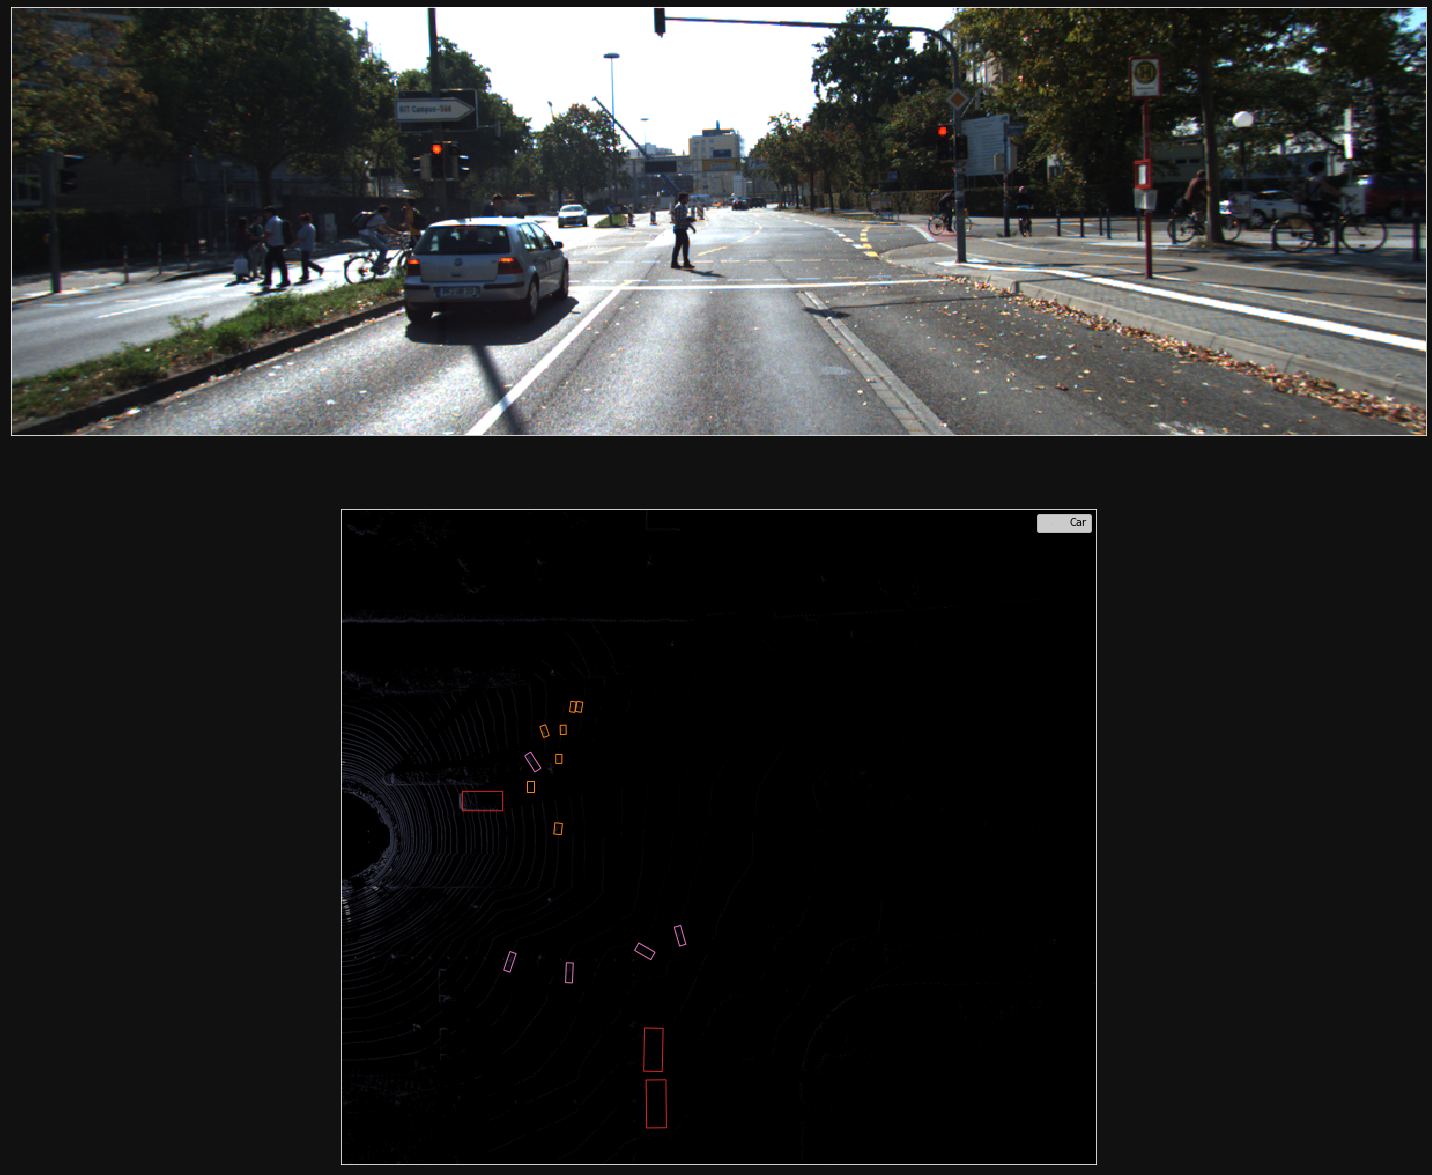

In [68]:
gt_dict = gt_dicts[idx]
pred_dict = pred_dicts[idx]
print(gt_dict['frame_id'])
points = load_lidar(gt_dict['frame_id'], xlim, ylim)
image = load_image(gt_dict['frame_id'])
scale = 0.32

plt.figure(figsize=(20, 18), facecolor=(0.067, 0.067, 0.067))

ax = plt.subplot(211)
plt.imshow(image)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
for spine in ax.spines.values():
    spine.set_edgecolor('white')

ax = plt.subplot(212)

ax.scatter(points[::-1,0], points[::-1,1], marker='.', s=0.01, c=points[:,3], cmap='bone')

ax.legend(('Car', 'Pedestrian', 'Cyclist'))

class_colors = ['tab:gray', 'tab:red', 'tab:orange', 'tab:pink', 'tab:gray']
for label, box in zip(gt_dict['gt_labels'], gt_dict['gt_boxes']):
    add_box(ax, box, color=class_colors[label])

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_aspect(1)
ax.set_facecolor('black')
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
for spine in ax.spines.values():
    spine.set_edgecolor('white')
    
plt.tight_layout()
plt.show()

# 2. View outputs from all forward passes

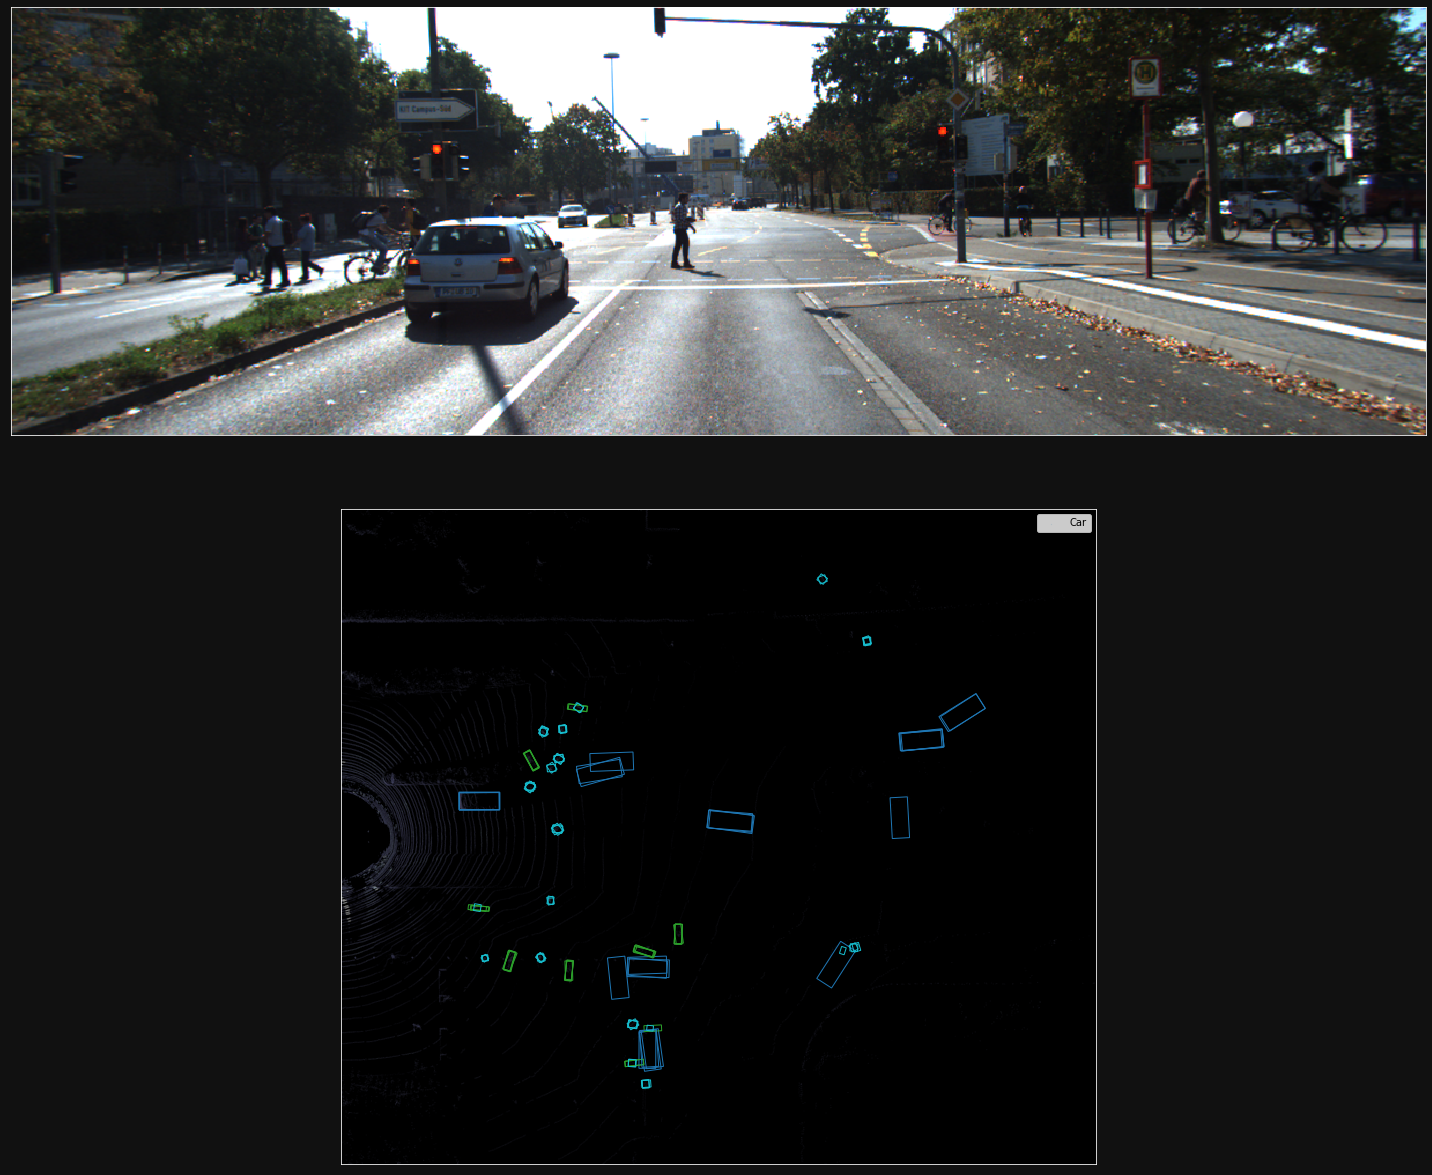

In [69]:
gt_dict = gt_dicts[idx]
pred_dict = pred_dicts[idx]
points = load_lidar(gt_dict['frame_id'], xlim, ylim)
image = load_image(gt_dict['frame_id'])
scale = 0.32

plt.figure(figsize=(20, 18), facecolor=(0.067, 0.067, 0.067))

ax = plt.subplot(211)
plt.imshow(image)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
for spine in ax.spines.values():
    spine.set_edgecolor('white')

ax = plt.subplot(212)

ax.scatter(points[::-1,0], points[::-1,1], marker='.', s=0.01, c=points[:,3], cmap='bone')

ax.legend(('Car', 'Pedestrian', 'Cyclist'))

class_colors = ['tab:gray', 'tab:blue', 'tab:cyan', 'tab:green', 'tab:gray']
# Display all pred_dicts for a frame
for single_pred_dict in pred_dict:
    for label, box in zip(np.argmax(single_pred_dict['score_all'][:,:-1], axis=-1)+1, single_pred_dict['boxes_lidar']):
        add_box(ax, box, color=class_colors[label])

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_aspect(1)
ax.set_facecolor('black')
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
for spine in ax.spines.values():
    spine.set_edgecolor('white')
    
plt.tight_layout()
plt.show()

# 3. View clustered output

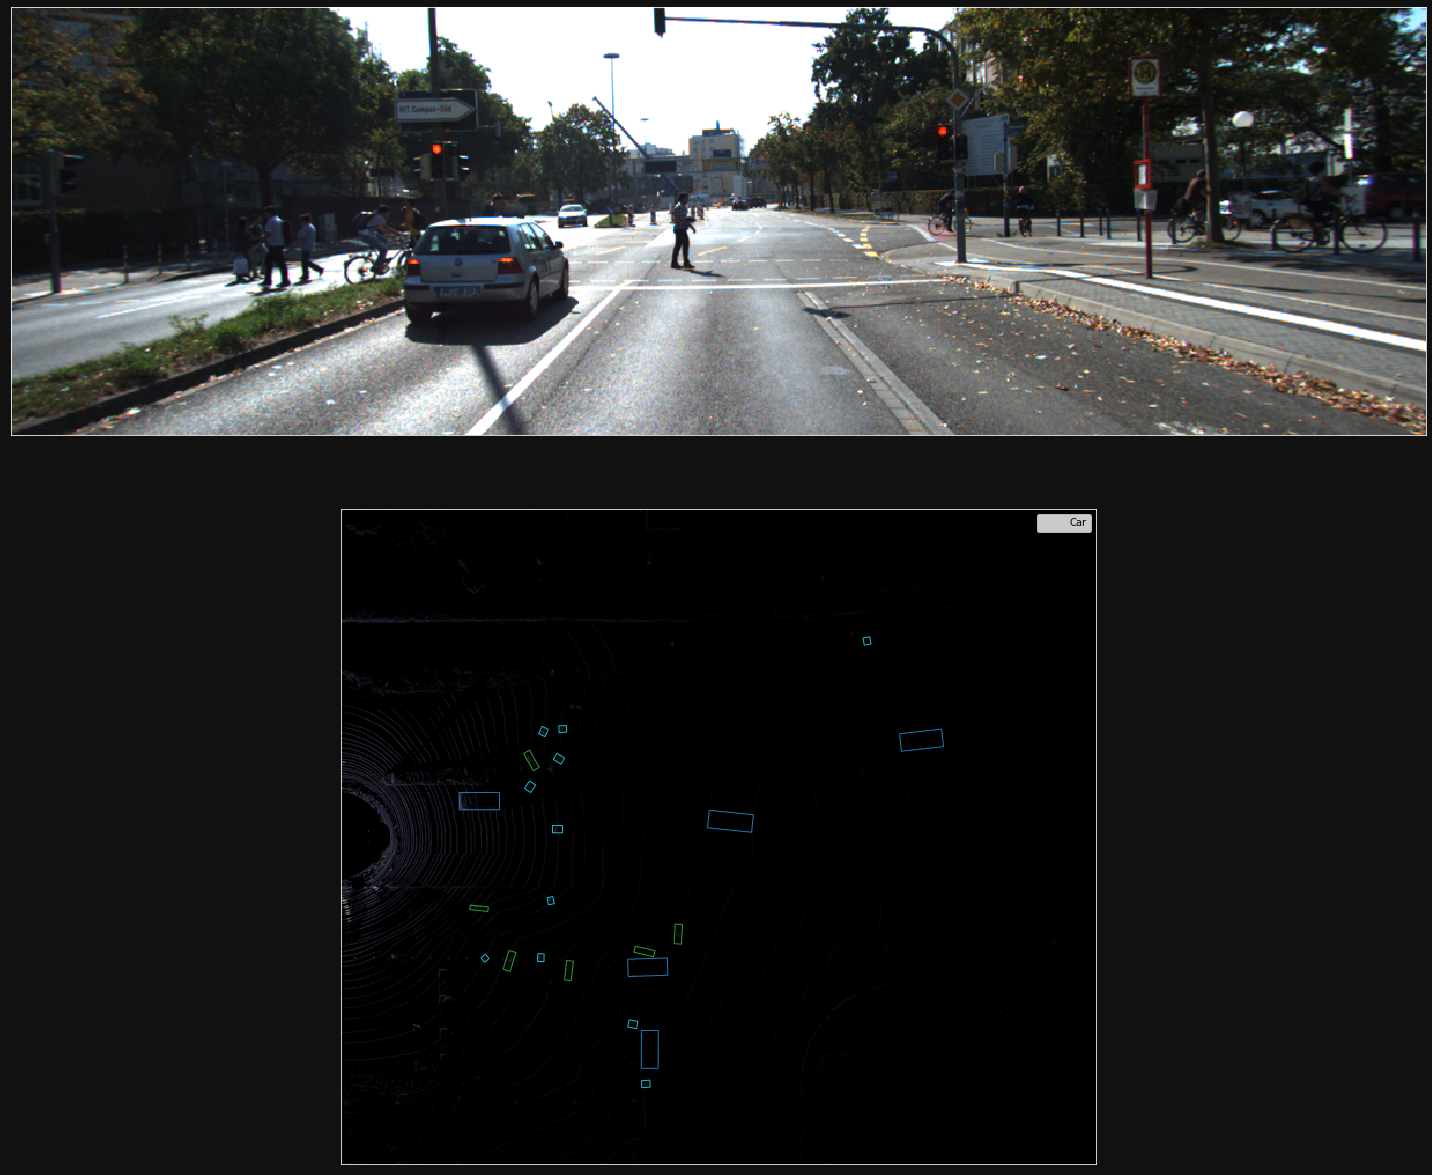

In [70]:
gt_dict = gt_dicts[idx]
pred_dict = clustered_pred_dicts[idx]
points = load_lidar(gt_dict['frame_id'], xlim, ylim)
image = load_image(gt_dict['frame_id'])
scale = 0.32

plt.figure(figsize=(20, 18), facecolor=(0.067, 0.067, 0.067))

ax = plt.subplot(211)
plt.imshow(image)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
for spine in ax.spines.values():
    spine.set_edgecolor('white')

ax = plt.subplot(212)

ax.scatter(points[::-1,0], points[::-1,1], marker='.', s=0.01, c=points[:,3], cmap='bone')

ax.legend(('Car', 'Pedestrian', 'Cyclist'))

class_colors = ['tab:gray', 'tab:blue', 'tab:cyan', 'tab:green', 'tab:gray']
for label, box in zip(np.argmax(pred_dict['score_all'][:,:-1], axis=-1)+1, pred_dict['boxes_lidar']):
    add_box(ax, box, color=class_colors[label])

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_aspect(1)
ax.set_facecolor('black')
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
for spine in ax.spines.values():
    spine.set_edgecolor('white')
    
plt.tight_layout()
plt.show()

# 4. View GT and clustered output

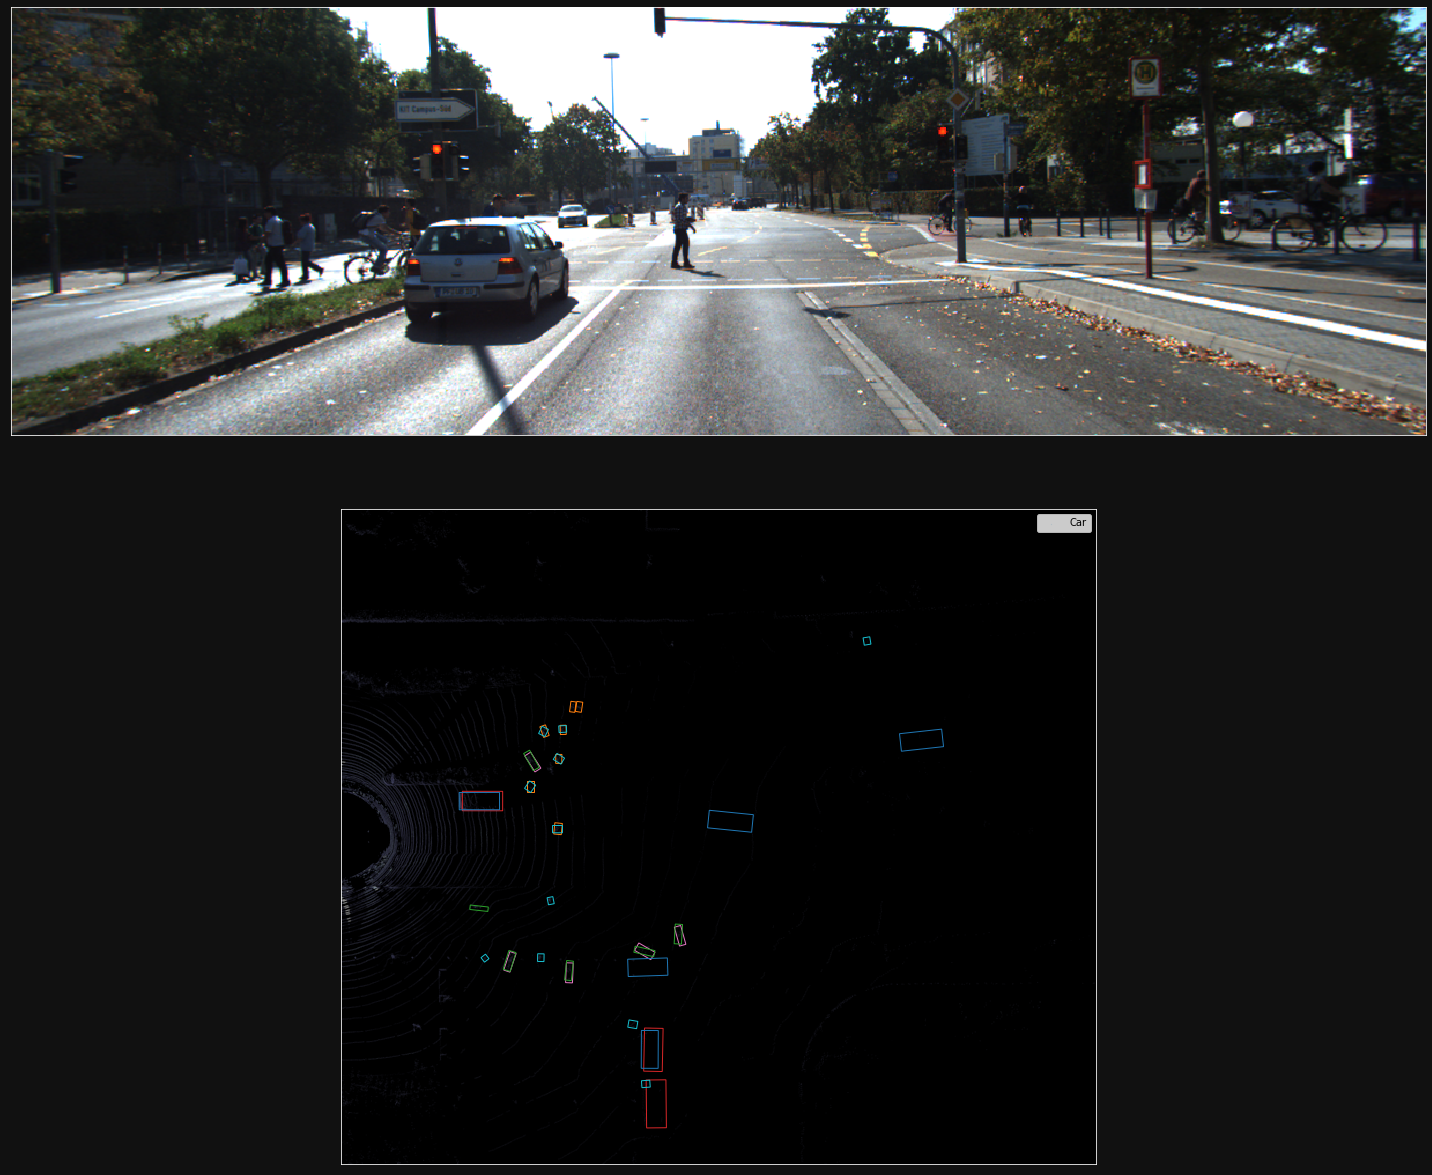

In [71]:
gt_dict = gt_dicts[idx]
pred_dict = clustered_pred_dicts[idx]
points = load_lidar(gt_dict['frame_id'], xlim, ylim)
image = load_image(gt_dict['frame_id'])
scale = 0.32

plt.figure(figsize=(20, 18), facecolor=(0.067, 0.067, 0.067))

ax = plt.subplot(211)
plt.imshow(image)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
for spine in ax.spines.values():
    spine.set_edgecolor('white')

ax = plt.subplot(212)

ax.scatter(points[::-1,0], points[::-1,1], marker='.', s=0.01, c=points[:,3], cmap='bone')

ax.legend(('Car', 'Pedestrian', 'Cyclist'))

class_colors = ['tab:gray', 'tab:red', 'tab:orange', 'tab:pink', 'tab:gray']
for label, box in zip(gt_dict['gt_labels'], gt_dict['gt_boxes']):
    add_box(ax, box, color=class_colors[label])

class_colors = ['tab:gray', 'tab:blue', 'tab:cyan', 'tab:green', 'tab:gray']
for label, box in zip(np.argmax(pred_dict['score_all'][:,:-1], axis=-1)+1, pred_dict['boxes_lidar']):
    add_box(ax, box, color=class_colors[label])

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_aspect(1)
ax.set_facecolor('black')
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
for spine in ax.spines.values():
    spine.set_edgecolor('white')
    
plt.tight_layout()
plt.show()